## **DAT 402 Project 1**   
## **Spotify Song Popularity Prediction**

**Team Members:**
- Pete VanBenthuysen
- Emily Szolnoki

**Project Goal:**
Predict whether a song will be popular (popularity $ \geq 59 $) based on its musical features, such as **danceability**, **energy**, and **tempo**. This project helps us identify which characteristics are most influential in determining whether a song becomes popular. We are most interested in analyzing and building a model to predict song popularity based on those musical attributes and more, allowing for potential insights in playlist curation and music production.

**Dataset:**
We are using a dataset from Kaggle called 'Ultimate Spotify Tracks DB'. The raw dataset includes 18 columns and 232,725 rows with a mix of categorical and numerical features. There are also no missing values.

 (https://www.kaggle.com/datasets/zaheenhamidani/ultimate-spotify-tracks-db)

**Columns:**
- **genre**: Genre of the song.
- **artist_name**: Name of the artist.
- **track_name**: Name of the track.
- **track_id**: Unique ID for each track.
- **popularity**: Popularity score of the song (ranging from 0 to 100).
- **acousticness**: A measure of how acoustic the song is (ranging from 0 to 1).
- **danceability**: How suitable the song is for dancing (ranging from 0 to 1).
- **duration_ms**: Duration of the trach in milliseconds.
- **energy**: A measure of energy, typically related to the intensity and activity of the track (ranging from 0 to 1).
- **instrumentalness**: A measure of whether the track is instrumental (ranging from 0 to 1).
- **key**: The musical key of the track.
- **liveness**: Measure of the presence of a live audience (ranging from 0 to 1).
- **loudness**: The overall loudness of the track in decibels.
- **mode**: The modality of the track.
- **speechiness**: Speechiness measure of the track (ranging from 0 to 1).
- **tempo**: The tempo (beats per minute) of the track.
- **time_signature**: The time signature of the track.
- **valence**: A measure of musical positiveness (ranging from 0 to 1).

### **Imports**

In [37]:
#%pip install pandas matplotlib seaborn scikit-learn imblearn

In [36]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Model selection & evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    mean_squared_error,
    precision_recall_fscore_support,
    precision_score,
    recall_score,
    r2_score,
    roc_auc_score,
    roc_curve
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV, train_test_split as tts

# Preprocessing
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import StandardScaler

### **Data Loading, Cleaning, and Preprocessing**

After importing all necessary libraries, we begin the exploratory data analysis by loading in the dataset and taking a look at the first few rows to understand its structure. We also check for any missing values to assess data quality. These steps will ensure that our data is clean and ready for analysis and modeling.

In [37]:
### 1) Loading, cleaning, and preprocessing the dataset ###

# Load dataset
df = pd.read_csv("data/SpotifyFeatures.csv", parse_dates=False) # Set parse_dates=False to avoid parsing dates
print("First 5 Rows of the Dataset:")
print(df.head())

print("Count of Missing Values in Each Column:")
print(df.isnull().sum()) # Check for missing values

First 5 Rows of the Dataset:
   genre        artist_name                        track_name  \
0  Movie     Henri Salvador       C'est beau de faire un Show   
1  Movie  Martin & les fées  Perdu d'avance (par Gad Elmaleh)   
2  Movie    Joseph Williams    Don't Let Me Be Lonely Tonight   
3  Movie     Henri Salvador    Dis-moi Monsieur Gordon Cooper   
4  Movie       Fabien Nataf                         Ouverture   

                 track_id  popularity  acousticness  danceability  \
0  0BRjO6ga9RKCKjfDqeFgWV           0         0.611         0.389   
1  0BjC1NfoEOOusryehmNudP           1         0.246         0.590   
2  0CoSDzoNIKCRs124s9uTVy           3         0.952         0.663   
3  0Gc6TVm52BwZD07Ki6tIvf           0         0.703         0.240   
4  0IuslXpMROHdEPvSl1fTQK           4         0.950         0.331   

   duration_ms  energy  instrumentalness key  liveness  loudness   mode  \
0        99373   0.910             0.000  C#    0.3460    -1.828  Major   
1       137373 

In [38]:
# Check for duplicate track_ids with different genres
dupes = df[df.duplicated(subset=['track_id'], keep=False)]
num_dupes = dupes['track_id'].nunique()
total_dupe_rows = dupes.shape[0]

print(f"\nFound {num_dupes} duplicated track_ids with conflicting genres.")
print(f"This affects a total of {total_dupe_rows} rows.\n")
print("Sample of duplicate conflicts:")
print(dupes[['track_id', 'track_name', 'genre']].sort_values(by='track_id').head(10))

before_dedup = df.shape[0]
# Remove duplicates based on track_id, keeping the first occurrence
df = df.drop_duplicates(subset='track_id', keep='first')
after_dedup = df.shape[0]

print(f"\nRemoved {before_dedup - after_dedup} duplicate rows based on track_id.\n")


Found 35124 duplicated track_ids with conflicting genres.
This affects a total of 91075 rows.

Sample of duplicate conflicts:
                      track_id           track_name             genre
14492   000xQL6tZNLJzIrtIgxqSl       Still Got Time             Dance
110840  000xQL6tZNLJzIrtIgxqSl       Still Got Time               Pop
96926   001gDjxhKGDSx4sMMAgS9R              Kingdom  Children’s Music
153533  001gDjxhKGDSx4sMMAgS9R              Kingdom              Rock
65253   001ifh9Zkyc5DhK7AGQRtK               Gemini              Folk
145387  001ifh9Zkyc5DhK7AGQRtK               Gemini             Indie
201614  002PgfoyfrOGiKch4EW8Wm    Jasmine Runs Away        Soundtrack
182413  002PgfoyfrOGiKch4EW8Wm    Jasmine Runs Away             Movie
121130  002QT7AS6h1LAF5dla8D92  Still Smell Like It               Rap
90714   002QT7AS6h1LAF5dla8D92  Still Smell Like It           Hip-Hop

Removed 55951 duplicate rows based on track_id.



Next, we check for duplicates in the dataset. Some songs appear multiple times in the dataset under the same **track_id** but with different genres. To create a more balanced and fair dataset, we remove all songs that have multiple occurrences of their **track_id**, excluding the first occurrence.

We identify the duplicates, assess how many rows were affected, include a sample of what a duplicated **track_id** looks like in the dataset, and remove them.

In [39]:
# Check output of time_signature
print("Proportion of Each Value in 'time_signature':")
print(df['time_signature'].value_counts(normalize=True))

# Remove rows with invalid time signature and convert to integer
df = df[df['time_signature'] != '0/4']
df['time_signature'] = df['time_signature'].str.extract('(\d+)').astype(int)

Proportion of Each Value in 'time_signature':
time_signature
4/4    0.843942
3/4    0.117698
5/4    0.025060
1/4    0.013266
0/4    0.000034
Name: proportion, dtype: float64


The **time_signature** column describes the number of beats in a measure. We remove 
invalid time signatures (like '0/4') to clean up the data and improve the accuracy of the distribution. We also convert the column to a numeric format.

In [40]:
# Convert duration from milliseconds to seconds for easier interpretation
df['duration_sec'] = df['duration_ms'] / 1000

To make the **duration_ms** feature more readable and intuitive, we create a new column called **duration_sec** to replace it.

In [41]:
# Fix the genre name
df['genre'] = df['genre'].replace("Children’s Music", "Children's Music") 

# Drop genres that are not relevant for our analysis
df = df[~df['genre'].isin(['Comedy', "Children's Music"])]

# Combine "Hip-Hop" and "Rap" into "Hip-Hop_Rap"
df['genre'] = df['genre'].replace({'Hip-Hop': 'Hip-Hop_Rap', 'Rap': 'Hip-Hop_Rap'})

# Check the updated genre distribution
print("\nCount of Each Genre in the Dataset:")
print(df['genre'].value_counts())

# Drop columns we don't want the model to use
df = df.drop(columns=['track_name', 'track_id', 'artist_name', 'duration_ms'])


Count of Each Genre in the Dataset:
genre
Electronic     9149
Alternative    9095
Anime          8935
Hip-Hop_Rap    8869
Classical      8711
Reggae         8687
Reggaeton      8549
Blues          8496
Soundtrack     8480
Opera          8277
Folk           8048
Jazz           8039
Ska            8017
Dance          7981
World          7972
Movie          7802
Country        7383
R&B            5353
Soul           4430
Indie          3318
Pop            2417
Rock           2227
A Capella       119
Name: count, dtype: int64


The **genre** column had quite a few inconsistences. We perform the following steps to clean and consolidate it:
- Fix the apostrophe in **Children's Music**.
- Remove irrelevent genres like **Comedy** and **Children's Music** since they are outside the scope of our analysis.
- Combine **Rap** and **Hip-Hop** genres into one to create a more even distribution throughout genres.

To simplify the dataset, we drop columns that won't be used by the model:
- **track_name**, **track__id**, and **artist_name** are removed because they do not necessarily contribute meaningful predictive value. 
- **duration_ms** is removed because it was replaced by the new columns **duration_sec**.

In [42]:
# Statistically define threshold for popularity based on top 10%
threshold = df['popularity'].quantile(0.90) # Top 10%
df['is_popular'] = (df['popularity'] >= threshold).astype(int)
print(f"\nUsing popularity threshold: {threshold:.2f}") #59.0
print("Class Distribution for 'is_popular' (Proportions):")
print(df['is_popular'].value_counts(normalize=True)) # Check class distribution

df = df.drop(columns=['popularity'])
df = df.drop_duplicates()


Using popularity threshold: 59.00
Class Distribution for 'is_popular' (Proportions):
is_popular
0    0.896766
1    0.103234
Name: proportion, dtype: float64



Next, we define a binary target variable called **is_popular**. A song is considered popular and labeled as 1 if its popularity score falls within the top 10% ($ \geq 59 $) of all songs in the dataset. Otherwise, it is marked as 0 (non-popular). We dropped the **popularity** after defining our binary target variable.

In [ ]:
# Final quality checks
print("\n Quality checks:")
print("Missing values:\n")
print(df.isnull().sum())       # Check for missing values

print("\nData types:\n")
print(df.dtypes)               # Confirm correct data types

print("\nColumns in dataset:")
print(list(df.columns))        # Final column names

# Final duplicate check
num_duplicates = df.duplicated(keep=False).sum()
print(f"\nExact duplicate rows: {num_duplicates}")

if num_duplicates > 0:
    print("Sample duplicates:\n", df[df.duplicated(keep=False)].head(10))
else:
    print("No exact duplicate rows found.")

# Dataset shape after cleaning
print(f"\nCleaned dataset shape: {df.shape}")

# List of columns after cleaning
print(f"\nColumns after cleaning: {df.columns.tolist()}")

To wrap up the loading and cleaning of this dataset, we run some final quality checks to ensure everything is accurate and ready for exploratory analysis. We confirm that there are **no** missing values, our column data types are **appropriate**, the column names are **all** listed, there are **no** duplicates, and our dataset shape is **accurate**.

### **Exploratory Data Analysis (EDA)**

To better understand the dataset and prepare for modeling, we conducted extensive exploratory data analysis.

In [44]:
### 1.5) EDA Checks ###

print(f"\nSummary statistics:\n{df.describe()}")  # Summary statistics
print(f"\nTime signature distribution:\n{df['time_signature'].value_counts(normalize=True)}")  # Categorical breakdown


Summary statistics:
        acousticness   danceability         energy  instrumentalness  \
count  159981.000000  159981.000000  159981.000000     159981.000000   
mean        0.376090       0.534982       0.554121          0.184452   
std         0.362517       0.193880       0.278229          0.330984   
min         0.000000       0.056900       0.000020          0.000000   
25%         0.037400       0.401000       0.338000          0.000000   
50%         0.236000       0.552000       0.592000          0.000154   
75%         0.740000       0.683000       0.787000          0.150000   
max         0.996000       0.987000       0.999000          0.999000   

            liveness       loudness    speechiness          tempo  \
count  159981.000000  159981.000000  159981.000000  159981.000000   
mean        0.196569     -10.020473       0.084368     118.181187   
std         0.171005       6.530106       0.093885      31.189596   
min         0.009670     -52.457000       0.022200    

We begin our EDA by examining summary statistics of our dataset. This will help us understand the scale and distribution of our features. We also take a look at the distribution of **time_signature** to understand the frequency of time signatures present in the songs.

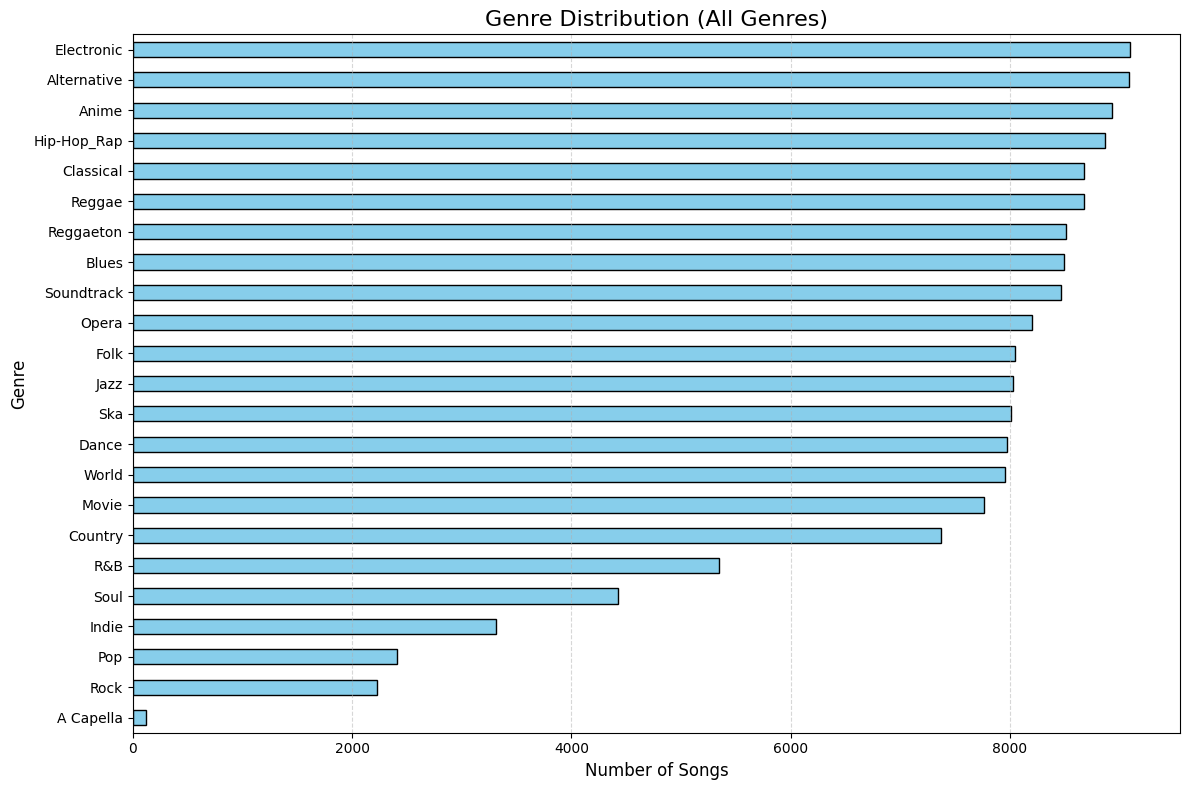

In [45]:
### 2) EDA ###

# Genre overview via bar chart
genre_counts = df['genre'].value_counts() # Count songs per genre
 
# Plot
plt.figure(figsize=(12, 8))
genre_counts.plot(kind='barh', color='skyblue', edgecolor='black')

# Add titles and labels
plt.title('Genre Distribution (All Genres)', fontsize=16)
plt.xlabel('Number of Songs', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Flip the y-axis to show most common genres on top
plt.gca().invert_yaxis()

# Display the plot
plt.tight_layout()
plt.show()

The first chart we are taking a look at is the distribution of genres in the dataset. It is a great bar chart to visualize, as it helps us make interpretations for which genres dominate over others (specifically in this dataset after cleaning).

We see that genres **Electronic** and **Alternative** roughly make up 18,000 out of 159,981 songs in the cleaned dataset. **A Capella** has the least amount of songs out of all of the genres. While there aren't any noticeable imbalances (besides **A Capella**), seeing this distribution helps us visualize those imbalances and can help us consider stratification or balancing methods later on in the project.

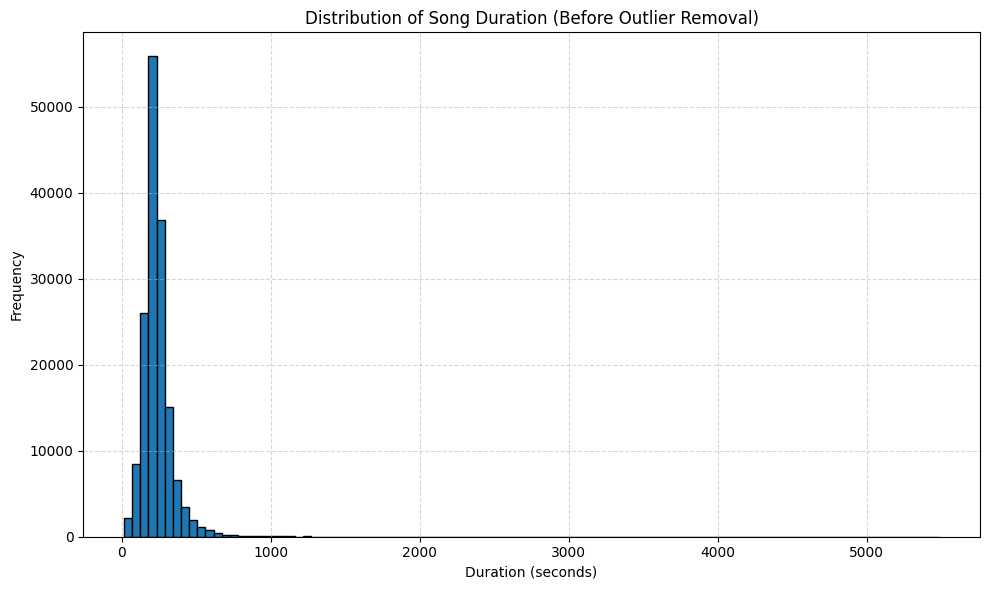


Duration IQR Analysis
Outliers detected: 9888
Songs removed from dataset: 9888
IQR Range: 54 to 400 seconds
Original duration range: 53.867 to 399.827 seconds
Remaining dataset size: 150,093 songs


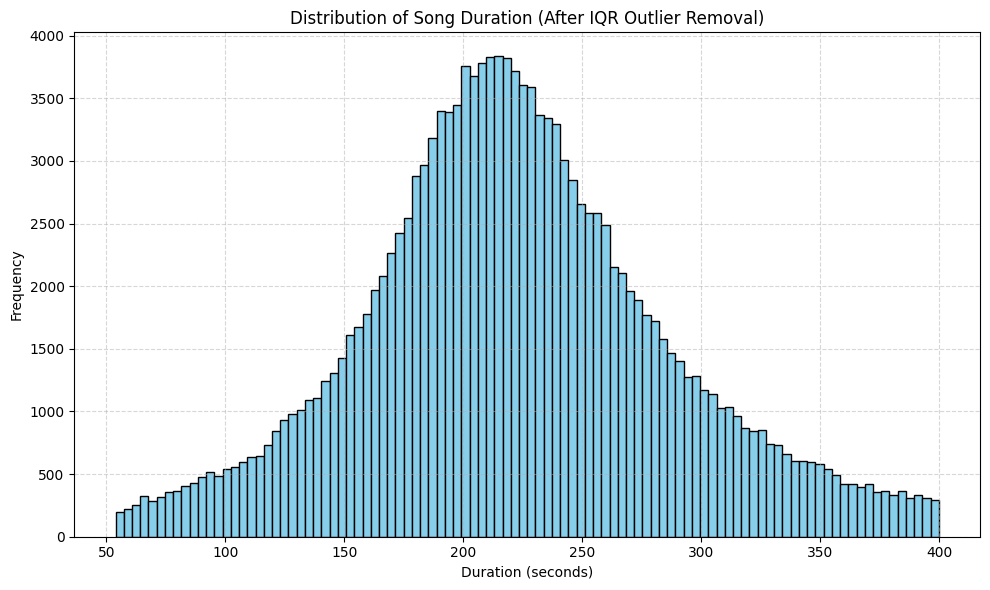

In [46]:
### IQR Analysis for Duration ###

# Bar chart before outlier removal
plt.figure(figsize=(10, 6))
plt.hist(df['duration_sec'], bins=100, edgecolor='black')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Song Duration (Before Outlier Removal)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# IQR Calculation for duration
Q1 = df['duration_sec'].quantile(0.25)
Q3 = df['duration_sec'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count outliers
total_before = df.shape[0]
outliers_detected = ((df['duration_sec'] < lower_bound) | (df['duration_sec'] > upper_bound)).sum()

# Remove outliers
df = df[(df['duration_sec'] >= lower_bound) & (df['duration_sec'] <= upper_bound)]
total_after = df.shape[0]
songs_removed = total_before - total_after

# Print IQR stats and impact
print("\nDuration IQR Analysis")
print(f"Outliers detected: {outliers_detected}")
print(f"Songs removed from dataset: {songs_removed}")
print(f"IQR Range: {lower_bound:.0f} to {upper_bound:.0f} seconds")
print(f"Original duration range: {df['duration_sec'].min():.3f} to {df['duration_sec'].max():.3f} seconds")
print(f"Remaining dataset size: {total_after:,} songs")

# Bar chart after duration outlier removal
plt.figure(figsize=(10, 6))
plt.hist(df['duration_sec'], bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Song Duration (After IQR Outlier Removal)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

To ensure that extremely short or long songs (duration of song) don't veer our analysis, we use an **Interquartile Range (IQR)** method to filter out those outliers. We use the **duration_sec** column to identify the length of those songs.

We calculate the IQR using the 25th percentile (Q1) and the 75th percentile (Q3). Any song that is outside of the IQR multiplied by 1.5 will be removed because they will be considered outliers in the dataset.

The IQR method is very helpful in our EDA because it helps us narrow down our dataset to focus on songs with more common durations. As you can see from the before and after of the bar plots, the range of duration is far more equally spread out.

We removed 9,888 songs. That is an impressive amount and will help our prediction models become more accurate.

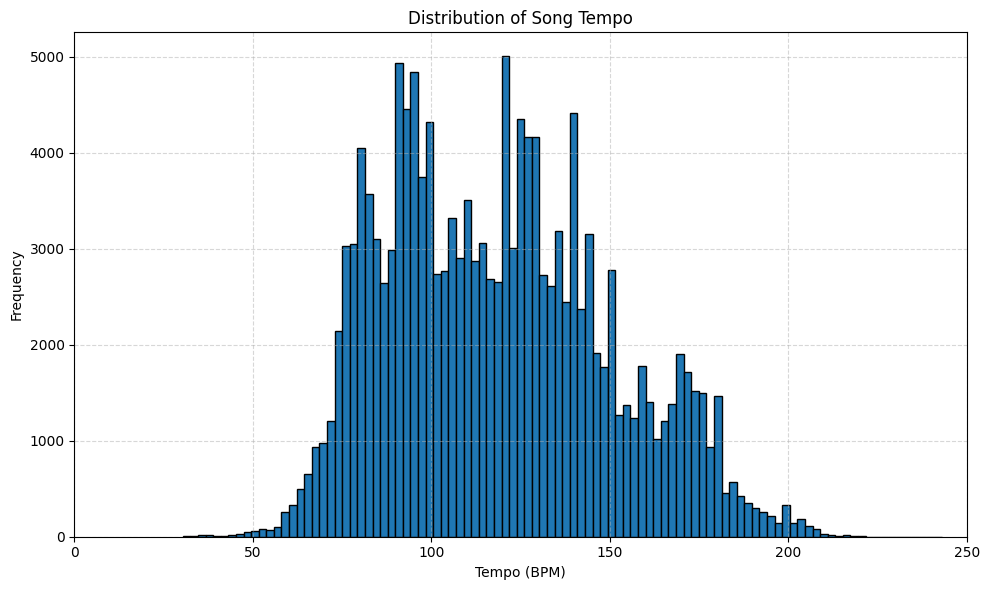

In [47]:
### IQR Analysis for Tempo ###

# Plot histogram of song tempo
plt.figure(figsize=(10, 6))
plt.hist(df['tempo'], bins=100, edgecolor='black')
plt.xlabel('Tempo (BPM)')
plt.ylabel('Frequency')
plt.title('Distribution of Song Tempo')
plt.xlim(0, 250)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

This histogram shows how **tempo** is distributed across all songs in the dataset.
- The first thing we notice is that there are several distinct peaks. We now know that the most common tempos within the songs are around **90**, **120**, and **140 BPM**.
- This suggests that there are certain tempos that are more popular than others, possibly because they align well with common rhythmic patterns are are ideal for dancing.
- There is more of a right-skewed tail, with some songs having higher tempos that exceed 200 BPM. There aren't many songs in this category, though.

This distribution definitely helps us identify the tempo range that songs tend to have and may help with determining if this is a factor for if a song is popular or not as well as indicate that there are not any outliers present within this feature.

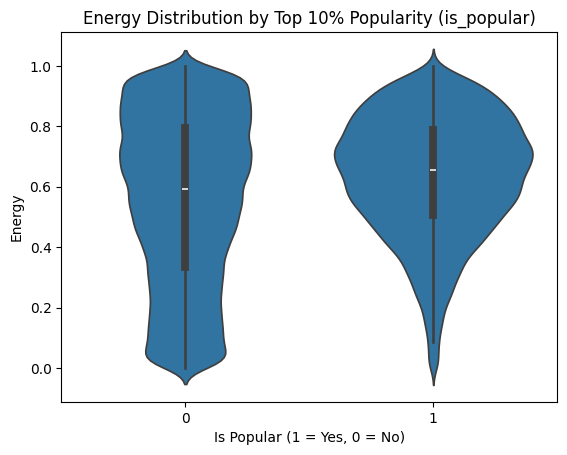

In [18]:
# Violin plot for is_popular vs energy
sns.violinplot(x='is_popular', y='energy', data=df)
plt.title('Energy Distribution by Top 10% Popularity (is_popular)')
plt.xlabel('Is Popular (1 = Yes, 0 = No)')
plt.ylabel('Energy')
plt.show()

The next graph that we analyze is a violin plot to visualize the distribution of **energy** for both popular and non-popular songs (this is defined by the top 10% popullarity threshold).
- While both categories show a wide range of energy, popular songs tend to have slightly higher energy levels on average.
- The spread for non-popular songs is broader and more evenly spread out, including more low-energy tracks.

This violin plot suggests that a song must have higher energy for it to have a higher chance of becoming popular. This makes sense because most mainstream songs are very energetic. This would allow the song to cater to a wider audience.

In [19]:
# Calculate IQR for energy based on is_popular
print("IQR (Popular):", df[df['is_popular'] == 1]['energy'].quantile(0.75) - df[df['is_popular'] == 1]['energy'].quantile(0.25))
print("IQR (Not Popular):", df[df['is_popular'] == 0]['energy'].quantile(0.75) - df[df['is_popular'] == 0]['energy'].quantile(0.25))

IQR (Popular): 0.281
IQR (Not Popular): 0.459


We also calculate the IQR for both popular and non-popular songs. These numbers confirm that popular songs have a more consistent energy level, while non-popular songs tend to have a more diverse energy spread. This tells us that popularity might be associated with a specific energetic sound.

Summary Statistics for Danceability:
count    150093.000000
mean          0.543978
std           0.190236
min           0.057000
25%           0.416000
50%           0.561000
75%           0.688000
max           0.987000
Name: danceability, dtype: float64

Summary Statistics for Loudness:
count    150093.000000
mean         -9.696042
std           6.341007
min         -52.457000
25%         -12.008000
50%          -7.686000
75%          -5.404000
max           3.744000
Name: loudness, dtype: float64


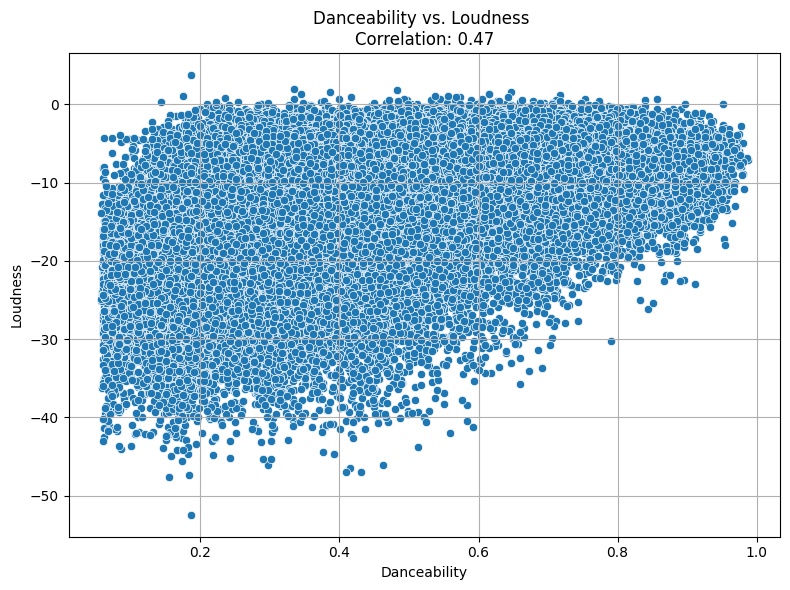

In [48]:
# Scatter plot for loudness vs. danceability
x = 'danceability'  # Defined variables
y = 'loudness'

corr_coeff = np.corrcoef(df[x], df[y])[0, 1] # Calculate the correlation coefficient

# Print summary statistics for both features
print(f"Summary Statistics for {x.capitalize()}:")
print(df[x].describe())
print(f"\nSummary Statistics for {y.capitalize()}:")
print(df[y].describe())

# Plot the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x, y=y, data=df)

# Annotate the plot with the correlation coefficient
plt.title(f'{x.capitalize()} vs. {y.capitalize()} \nCorrelation: {corr_coeff:.2f}')
plt.xlabel(x.capitalize())
plt.ylabel(y.capitalize())
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

This scatter plot helps us see the relationship between **danceability** and **loudness** of songs in the dataset.

The Pearson correlation coefficient is **0.47**, which indicates a moderately positive relationship between these two variables. This means that louder songs do actually tend to be more danceable. However, that is only generally.
- Most songs fall within the loudness range of **-30 dB to 0 dB**.
- A few outliers exist in loudness, however, danceability scores are mostly between **0.4 and 0.8**.

This scatter plot suggests that there is definitely a correlation between danceability and loudness and will be useful features for analyzing and predicting song popularity.

Summary Statistics for Loudness:
count    150093.000000
mean         -9.696042
std           6.341007
min         -52.457000
25%         -12.008000
50%          -7.686000
75%          -5.404000
max           3.744000
Name: loudness, dtype: float64

Summary Statistics for Energy:
count    150093.000000
mean          0.565372
std           0.274110
min           0.000020
25%           0.361000
50%           0.605000
75%           0.794000
max           0.999000
Name: energy, dtype: float64


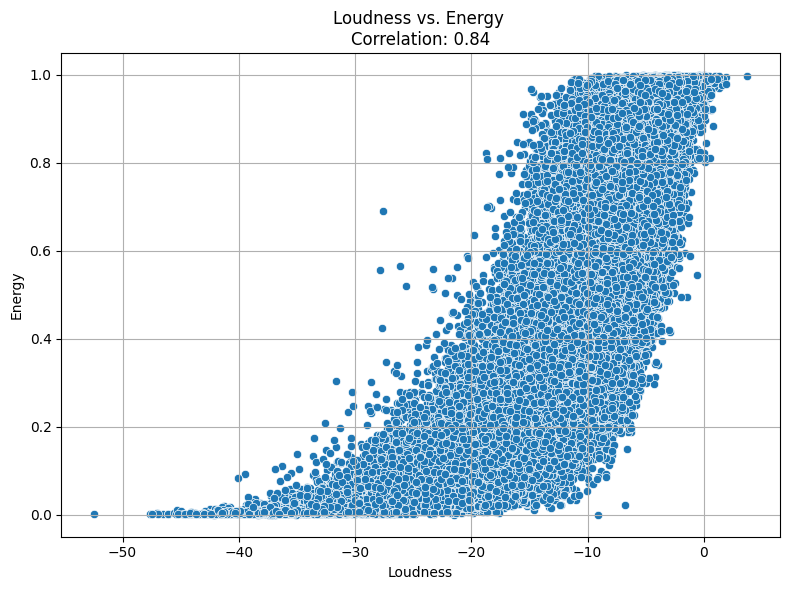

In [49]:
# Scatter plot for loudness vs energy
x = 'loudness' # Defined variables
y = 'energy'

# Calculate the correlation coefficient
corr_coeff = np.corrcoef(df[x], df[y])[0, 1]

# Print summary statistics for both features
print(f"Summary Statistics for {x.capitalize()}:")
print(df[x].describe())
print(f"\nSummary Statistics for {y.capitalize()}:")
print(df[y].describe())

# Plot the scatter plot of loudness vs energy
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x, y=y, data=df)

# Annotate the plot with the correlation coefficient
plt.title(f'{x.capitalize()} vs. {y.capitalize()} \nCorrelation: {corr_coeff:.2f}')
plt.xlabel(x.capitalize())
plt.ylabel(y.capitalize())
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

This scatter plot displays the relationship between **loudness** and **energy**. 

The Pearson correlation coefficient is **0.84**, which is very strong and positive! This means that as loudness increases, energy tends to increase. This applies to a very large chunk of songs that are in the dataset, aside from a few outliers. This makes sense because as loudness increases, songs usually feel more energetic and intense.
- There is a steep upward trend in energy as loudness increases from **-30 dB to 0 dB**.
- The distribution is more spread out at lower loudness levels but gets tighter once it reaches higher energy.

This is a strong relationship and suggests that loudness is a very strong predictor of energy in this dataset.

In [ ]:
# Print the correlation coefficient
print(f"\nCorrelation between {x} and {y}: {corr_coeff:.2f}")

# Calculate pairwise correlation of features
corr_matrix = df[['danceability', 'energy', 'loudness', 'speechiness', 
                  'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Feature Interaction Correlation Matrix')
plt.show()

Our final visualization is a correlation matrix. This heatmap displays the correlation coefficients between all of the numerical features in our dataset. 
- It is very prominent that **energy** and **loudness** have a strong positive correlation. This aligns with our "Loudness vs. Energy" scatter plot!
- **Danceability** and **valence** have the next higheset correlation coefficient. This suggests that there is a moderate correlation to happier songs being more danceable.
- **Acousticness** and **energy** are very negatively correlated. This means that songs that are acoustic tend to be quieter and less energetic, which makes sense as well.

This matrix gives us great insight! It allows us to spot which features may be redundant and which are most predictive for modeling.

In [23]:
# Data point check
print(f"After EDA and cleaning, the final dataset contains {df.shape[0]:,} songs.")

# Column check after EDA
print(f"\nColumns after EDA: {df.columns.tolist()}")

After EDA and cleaning, the final dataset contains 150,093 songs.

Columns after EDA: ['genre', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence', 'duration_sec', 'is_popular']


Here, we are finalizing the dataset shape and column names after EDA.

### **Feature Engineering**

In [52]:
### 3) Feature Engineering ###

# Convert mode from string to binary: Major = 1, Minor = 0
df['mode'] = df['mode'].map({'Minor': 0, 'Major': 1})

# One-hot encode genre variables
df = pd.get_dummies(df, columns=['genre', 'key'])

# One-hot encode time_signature variables
df = pd.get_dummies(df, columns=['time_signature'], prefix='ts')

# Create a new feature for vocalness as the inverse of instrumentalness (more vocals = less instrumental)
df['vocalness'] = 1 - df['instrumentalness']

# Bin tempo into categories: slow, medium, fast
df['tempo_category'] = pd.cut(
    df['tempo'],
    bins=[0, 90, 120, float('inf')],
    labels=['slow', 'medium', 'fast']
)

# One-hot encode tempo_category
df = pd.get_dummies(df, columns=['tempo_category'])

We applied several transformations to prepare our dataset for model training:
- Converted the **mode** column from string values to binary values.
- One-hot encoded the **genre** and **key** columns too preserve their meaning without introducing order.
- Created a new feature column called **vocalness** that analyzes the vocal-heaviness of a song, rather than its instrumentalness.
- Binned and one-hot encoded a new feature column called **tempo_category** from **tempo** into three categories: slow, medium, and fast.

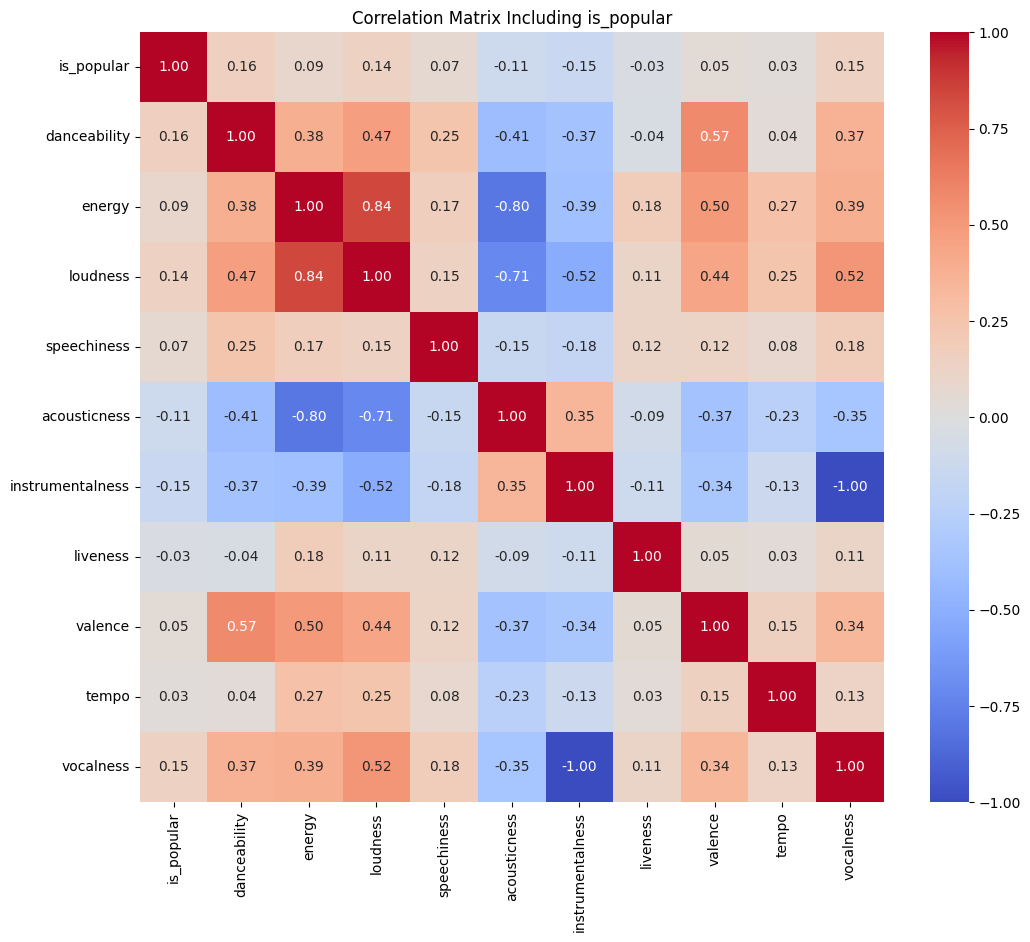

In [26]:
# Calculate correlation matrix including the target variable
corr_matrix = df[['is_popular', 'danceability', 'energy', 'loudness', 'speechiness', 
                  'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
                  'vocalness']].corr()
                  
# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix Including is_popular')
plt.show()

We also calculated another correlation matrix that included our target variable, **is_popular**.
- **Loudness** and **energy** remain very highly correlated.
- **Vocalness** appears to be moderately correlated with our target variable.

This feature engineering enhances our model performance by introducing interpretability and reducing noise.

In [53]:
# Drop the original instrumentalness column
df.drop(columns=['instrumentalness'], inplace=True)

# Drop the original tempo column to avoid redundancy
df.drop(columns=['tempo'], inplace=True)

Lastly, we dropped columns that were no longer needed after transformation:
- **Instrumentalness** (replaced by **vocalness**)
- **Tempo** (replaced by tempo categories)

In [54]:
# Data checkpoint after feature engineering
print("\nChecking for missing values in the dataset after feature engineering...") # Check for missing values in each column
missing_values = df.isnull().sum()
print("Missing values by column:")
print(missing_values) 
print("\nChecking for duplicate rows in the dataset...")
duplicates = df.duplicated().sum()

if duplicates > 0:
    print(f"Found {duplicates} duplicate rows.")
else:
    print("No duplicate rows found.")

print(f"\nAfter feature engineering, the dataset contains {df.shape[0]:,} songs.")

# Column check after feature engineering
print(f"\nColumns after feature engineering: {df.columns.tolist()}")


Checking for missing values in the dataset after feature engineering...
Missing values by column:
acousticness             0
danceability             0
energy                   0
liveness                 0
loudness                 0
mode                     0
speechiness              0
valence                  0
duration_sec             0
is_popular               0
genre_A Capella          0
genre_Alternative        0
genre_Anime              0
genre_Blues              0
genre_Classical          0
genre_Country            0
genre_Dance              0
genre_Electronic         0
genre_Folk               0
genre_Hip-Hop_Rap        0
genre_Indie              0
genre_Jazz               0
genre_Movie              0
genre_Opera              0
genre_Pop                0
genre_R&B                0
genre_Reggae             0
genre_Reggaeton          0
genre_Rock               0
genre_Ska                0
genre_Soul               0
genre_Soundtrack         0
genre_World              0
key_A     

Before we proceed with splitting and modeling, we performed a few quick data quality checks to ensure the dataset is clean and ready!

We verified that there are no missing values or duplicates in any column.

After feature engineering, our dataset now contains 150,093 songs and confirms that it is well-structured and ready for building predictive models.

### **Train/Validation/Test Split**

In [55]:
### 4) Training/Testing Dataset Using Train/Validation/Test Splits ###

# First split: 80% train_val, 20% test
train_val_df, test_df = tts(
    df, test_size=0.2, stratify=df['is_popular'], random_state=42
)

# Second split: 75% train, 25% val from train_val → ends up as 60/20/20
train_df, val_df = tts(
    train_val_df, test_size=0.25, stratify=train_val_df['is_popular'], random_state=42
)

# Define feature columns after splitting from the original df
feature_cols = df.columns[df.columns != 'is_popular']

# Use reindex to align columns for each split
X_train = train_df.reindex(columns=feature_cols, fill_value=0)
y_train = train_df['is_popular']

X_val = val_df.reindex(columns=feature_cols, fill_value=0)
y_val = val_df['is_popular']

X_test = test_df.reindex(columns=feature_cols, fill_value=0)
y_test = test_df['is_popular']

# Output clean summary
print("\nTrain size:", X_train.shape)
print("Validation size:", X_val.shape)
print("Test size:", X_test.shape)
print("Training class distribution:", y_train.value_counts().to_dict())

# Column check after splitting
print(f"\nColumns after splitting: {X_train.columns.tolist()}")


Train size: (90055, 52)
Validation size: (30019, 52)
Test size: (30019, 52)
Training class distribution: {0: 80278, 1: 9777}

Columns after splitting: ['acousticness', 'danceability', 'energy', 'liveness', 'loudness', 'mode', 'speechiness', 'valence', 'duration_sec', 'genre_A Capella', 'genre_Alternative', 'genre_Anime', 'genre_Blues', 'genre_Classical', 'genre_Country', 'genre_Dance', 'genre_Electronic', 'genre_Folk', 'genre_Hip-Hop_Rap', 'genre_Indie', 'genre_Jazz', 'genre_Movie', 'genre_Opera', 'genre_Pop', 'genre_R&B', 'genre_Reggae', 'genre_Reggaeton', 'genre_Rock', 'genre_Ska', 'genre_Soul', 'genre_Soundtrack', 'genre_World', 'key_A', 'key_A#', 'key_B', 'key_C', 'key_C#', 'key_D', 'key_D#', 'key_E', 'key_F', 'key_F#', 'key_G', 'key_G#', 'ts_1', 'ts_3', 'ts_4', 'ts_5', 'vocalness', 'tempo_category_slow', 'tempo_category_medium', 'tempo_category_fast']


To prepare our dataset for modeling, we split the data into 3 parts:
- Training set
- Validation set
- Test set

First, we split the dataset into **train_val** (80%) and **test** (20%). Stratifying by **is_popular** ensures that it maintains its class balance.

Second, we split the **train_val** portion into **train** (75%) and **validation** (25%) using stratification.

We also defined our **feature columns** by selecting all numeric columns except for **is_popular** because it is our target variable. They were aligned using **reindex()** to ensure all splits shared the same structure.

This setup allows us to train the model, tune hyperparameters, and evaluate generalizability on separate data splits.

After splitting, we successfully have a 60/20/20 split. This gives us a solid foundation for training and tuning.

### **Rescaling the Data**


Now, we are rescaling our data set so that we can have a more accurate prediction on whether a song will become popular or not. It is important that we standardize our dataset because, for example, **tempo** (ranging from 30 to 250) would overpower **energy** (ranging from 0 to 1) if we didn't rescale so this is definitely an important step.

In [ ]:
### 5) Rescaling Training Data ###

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler only on the training data
scaler.fit(X_train)

# Transform the training data using the fitted scaler
X_train_scaled = scaler.transform(X_train)

# Transform the validation and test data using the same scaler (no fitting, just transforming)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Print the first few rows of the scaled data to ensure it looks correct
print("\nScaled Training Data (first few rows):")
print(X_train_scaled[:5])

# Create separate SMOTETomek objects for each model to avoid overwriting

# For Logistic Regression (scaled features)
sm_lr = SMOTETomek(random_state=42)
X_train_resampled_lr, y_train_resampled_lr = sm_lr.fit_resample(X_train_scaled, y_train)

# For Random Forest (unscaled features)
sm_rf = SMOTETomek(random_state=42)
X_train_resampled_rf, y_train_resampled_rf = sm_rf.fit_resample(X_train, y_train)


Because this dataset is imbalanced, we use SMOTETomek to balance the training data. We created two separate SMOTETomek-resampled datasets:
- One for **Logistic Regression**, using scaled features (**X_train_scaled**).
- One for **Random Forest**, using unscaled features since tree-based models don't require scaling (**X_train**).

This process prepares both models for fair training without being biased toward the majority class.

In [31]:
print("\nBefore oversampling:", np.bincount(y_train))
print("After oversampling for Logistic Regression:", np.bincount(y_train_resampled_lr))
print("After oversampling for Random Forest:", np.bincount(y_train_resampled_rf))


Before oversampling: [80278  9777]
After oversampling for Logistic Regression: [79975 79975]
After oversampling for Random Forest: [80193 80193]


This code reveals the **is_popular** feature column before and after oversampling.

### **Training and Tuning Candidate Models**

Now that our data is cleaned, engineered, and balanced, we move into training and evaluating predictive models. Our objective was to maximize ROC AUC, a robust metric for binary classification.

In [32]:
### 6) Train/Tune Candidate Models ###

# Logistic Regression Model

# Define multiple Logistic Regression solver configurations
logreg_models = [
    {
        'model': LogisticRegression(solver='liblinear', max_iter=1000, class_weight='balanced'),
        'params': {
            'penalty': ['l1', 'l2'],
            'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
        }
    },
    {
        'model': LogisticRegression(solver='saga', max_iter=1000, class_weight='balanced'),
        'params': [
            {
                'penalty': ['l1', 'l2'],
                'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
            },
            {
                'penalty': ['elasticnet'],
                'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                'l1_ratio': [0.0, 0.5, 1.0]  # Only for elasticnet
            }
        ]
    },
    {
        'model': LogisticRegression(solver='lbfgs', max_iter=1000, class_weight='balanced'),
        'params': {
            'penalty': ['l2'],
            'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
        }
    }
]

# Create a StratifiedKFold object for stratified cross-validation
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Loop through each configuration and run GridSearchCV
best_score = 0
best_model = None
best_params = None

for config in logreg_models:
    grid = GridSearchCV(
        estimator=config['model'],
        param_grid=config['params'],
        cv=stratified_kfold, # Stratified K-Fold cross-validation
        scoring='roc_auc', # Use AUC as scoring metric
        n_jobs=-1,
        verbose=1
    )
    
    grid.fit(X_train_resampled_lr, y_train_resampled_lr)
    
    print(f"\nSolver: {config['model'].solver}")
    print("Best Parameters for Logistic Regression:", grid.best_params_)
    print("Best cross-validation ROC AUC score for Logistic Regression:", grid.best_score_)
   
    
    if grid.best_score_ > best_score:
        best_score = grid.best_score_
        best_model = grid.best_estimator_
        best_params = grid.best_params_

# Save the best performing model
best_logreg = best_model

print("\nBest Logistic Regression Model (Key Parameters):")
print(best_logreg)

Fitting 10 folds for each of 14 candidates, totalling 140 fits


Traceback (most recent call last):
  File "/Users/emilyszolnoki/envs/venv/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py", line 422, in _on_run
    cmd.send(self.sock)
  File "/Users/emilyszolnoki/envs/venv/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_net_command.py", line 111, in send
    sock.sendall(("Content-Length: %s\r\n\r\n" % len(as_bytes)).encode("ascii"))
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/emilyszolnoki/envs/venv/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_daemon_thread.py", line 53, in run
    self._on_run()
  File "/Users/emilyszolnoki/envs/venv/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py", line 432, in _on_run
    self.py_db.dispose_and_kill_all_pydevd_threads()
  File "/Users/emilyszolnoki/envs/venv/lib/python3.9/sit


Solver: liblinear
Best Parameters for Logistic Regression: {'C': 0.1, 'penalty': 'l2'}
Best cross-validation ROC AUC score for Logistic Regression: 0.8978149955145407
Fitting 10 folds for each of 35 candidates, totalling 350 fits

Solver: saga
Best Parameters for Logistic Regression: {'C': 0.01, 'l1_ratio': 0.0, 'penalty': 'elasticnet'}
Best cross-validation ROC AUC score for Logistic Regression: 0.8978215855702076
Fitting 10 folds for each of 7 candidates, totalling 70 fits


/Users/emilyszolnoki/envs/venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Traceback (most recent call last):
  File "/Users/emilyszolnoki/envs/venv/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py", line 422, in _on_run
    cmd.send(self.sock)
  File "/Users/emilyszolnoki/envs/venv/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_net_command.py", line 111, in send
    sock.sendall(("Content-Length: %s\r\n\r\n" % len(as_bytes)).encode("ascii"))
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/emilyszolnoki/envs/venv/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_daemon_thread.py", line 53, in run
    se


Solver: lbfgs
Best Parameters for Logistic Regression: {'C': 0.01, 'penalty': 'l2'}
Best cross-validation ROC AUC score for Logistic Regression: 0.897825067433546

Best Logistic Regression Model (Key Parameters):
LogisticRegression(C=0.01, class_weight='balanced', max_iter=1000)


We begin with **Logistic Regression** as a strong, interpretable baseline. We use **GridSearchCV** to tune hyperparameters for 3 different solver configurations, aiming to maximize the **ROC AUC**:
- **liblinear**
- **saga**
- **lbfgs**

The models were trained using the rescaled training set using 10-fold cross-validation. It is being evaluated using **ROC AUC**, which measures the model's abillity to distinguish between classes and is very important in our case.

The model that had the highest ROC AUC was the **liblinear** Solver. It had a ROC AUC of about **0.80** and was saved as our best performing logistic regression model.

In [33]:
#Random Forest Model
# Define the parameter distributions for Random Forest
param_dist_rf = {
    'n_estimators': [50, 100,],       # Number of trees, removed 200 to try to prevent overfitting
    'max_depth': [5, 10, 20],         # Depth of trees, removed "None" to try to prevent overfitting
    'min_samples_split': [2, 5, 10],  # Min samples to split
    'max_features': ['sqrt',] #'log2', None]  # Feature subset at each split, coded out None and log2 to save computational
}

# Initialize StratifiedKFold for cross-validation (10-fold)
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize RandomizedSearchCV with Random Forest
random_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_distributions=param_dist_rf,
    n_iter=18,                  # 25 random combinations
    cv=stratified_kfold,        # Stratified K-Fold cross-validation
    scoring='roc_auc',          # Use AUC as scoring metric
    n_jobs=-1,                  # Use all available CPU cores
    verbose=1,                  
    random_state=42            
)

# Fit the model on the training data (no scaling needed for Random Forest)
random_rf.fit(X_train_resampled_rf, y_train_resampled_rf)

# Output the best hyperparameters and best cross-validation score
print("\nBest parameters for Random Forest:", random_rf.best_params_)
print("\nBest cross-validation ROC AUC score for Random Forest:", random_rf.best_score_)

# Save the best model for future use
best_rf = random_rf.best_estimator_

print("\nBest Random Forest Model (Key Parameters):")
print(best_rf)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


Traceback (most recent call last):
  File "/Users/emilyszolnoki/envs/venv/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py", line 422, in _on_run
    cmd.send(self.sock)
  File "/Users/emilyszolnoki/envs/venv/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_net_command.py", line 111, in send
    sock.sendall(("Content-Length: %s\r\n\r\n" % len(as_bytes)).encode("ascii"))
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/emilyszolnoki/envs/venv/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_daemon_thread.py", line 53, in run
    self._on_run()
  File "/Users/emilyszolnoki/envs/venv/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py", line 432, in _on_run
    self.py_db.dispose_and_kill_all_pydevd_threads()
  File "/Users/emilyszolnoki/envs/venv/lib/python3.9/sit


Best parameters for Random Forest: {'n_estimators': 100, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 20}

Best cross-validation ROC AUC score for Random Forest: 0.9728427639156514

Best Random Forest Model (Key Parameters):
RandomForestClassifier(class_weight='balanced', max_depth=20, random_state=42)


After training a Logistic Regression model, we now explore a **Random Forest Classifier**. 

To optimize the Random Forest, we use **RandomizedSearchCV** to evaluate 18 random combinations of hyperparameters.

Our Random Forest model went through randomized hyperparameter tuning using 10-fold cross-validation and was scored using **ROC AUC**.

The best perfoming model was found with the following parameters:
- **n_estimators**: 100
- **min_samples_split**: 5
- **max_depth**: 10
- **max_features**: 'sqrt'

This configuration achieved a cross-validation ROC AUC of about **0.89**. This makes it the strongest candidate compared to the Logistic Regression model and will be used as our primary model for threshold tuning and final test evaluation.

In [58]:
### 6.5) Evaluating Tuned Models on the Validation Set ###

# Making predictions on the validation set

# Function to plot threshold metrics
def plot_threshold_metrics(thresholds, f1_scores, precisions, recalls, accuracies, title='Metric Performance vs. Classification Threshold'):
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, f1_scores, label='F1 Score', marker='o')
    plt.plot(thresholds, precisions, label='Precision', marker='o')
    plt.plot(thresholds, recalls, label='Recall', marker='o')
    plt.plot(thresholds, accuracies, label='Accuracy', marker='o')
    plt.axvline(0.5, color='gray', linestyle='--', label='Default Threshold (0.5)')
    plt.title(title)
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Now, we will evaluate both models (Logistic Regression and Random Forest) on the validation set before using the final model for testing. This step is important to see how well the models generalize to unseen data.


We will be calculating key metrics such as:
- **F1 Score**
- **Precision**
- **Recall**
- **Accuracy**

We will also experiment with different classification thresholds to understand how model performance changes when the decision boundary is adjusted.

In [59]:
# Random Forest: Threshold Tuning

# Get predicted probabilities from the random forest model
y_val_probs_rf = best_rf.predict_proba(X_val)[:, 1]

# Store metrics for different thresholds
thresholds_rf = np.arange(0.1, 0.9, 0.05)
f1_scores_rf, precisions_rf, recalls_rf, accuracies_rf = [], [], [], []

for thresh in thresholds_rf:
    y_pred_thresh_rf = (y_val_probs_rf >= thresh).astype(int)
    
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred_thresh_rf, average='binary')
    acc = accuracy_score(y_val, y_pred_thresh_rf)

    precisions_rf.append(precision)
    recalls_rf.append(recall)
    f1_scores_rf.append(f1)
    accuracies_rf.append(acc)

# Find best threshold based on F1 score
best_idx_rf = np.argmax(f1_scores_rf)
best_threshold_rf = thresholds_rf[best_idx_rf]
print(f"\nBest threshold for Random Forest (by F1-score): {best_threshold_rf:.2f}")
print(f"Precision: {precisions_rf[best_idx_rf]:.2f}, Recall: {recalls_rf[best_idx_rf]:.2f}, F1: {f1_scores_rf[best_idx_rf]:.2f}, Accuracy: {accuracies_rf[best_idx_rf]:.2f}")

# Make final predictions using the best threshold
y_val_pred_rf_thresh = (y_val_probs_rf >= best_threshold_rf).astype(int)

# Final Random Forest Validation Performance
print("\nRandom Forest - Validation Set Performance (Threshold = {:.2f}):".format(best_threshold_rf))
print(classification_report(y_val, y_val_pred_rf_thresh))


Best threshold for Random Forest (by F1-score): 0.55
Precision: 0.49, Recall: 0.63, F1: 0.55, Accuracy: 0.89

Random Forest - Validation Set Performance (Threshold = 0.55):
              precision    recall  f1-score   support

           0       0.95      0.92      0.94     26760
           1       0.49      0.63      0.55      3259

    accuracy                           0.89     30019
   macro avg       0.72      0.77      0.74     30019
weighted avg       0.90      0.89      0.89     30019



After training and tuning our Random Forest model, we evaluated its performance on the **validation set** by varying the classification threshold.

We looped through multiple thresholds and calculated key metrics at each level.

The best threshold for the Random Forest model, by F1 Score, is **0.55**. We find that at this threshold that **precision** is a 0.49.

Overall, this model does a good job at identifying most of the **truly** popular songs because of its high **recall** at 63%. This could be valuable if we want to prioritize the discovery of potential hits, even at the cost of false alarms.



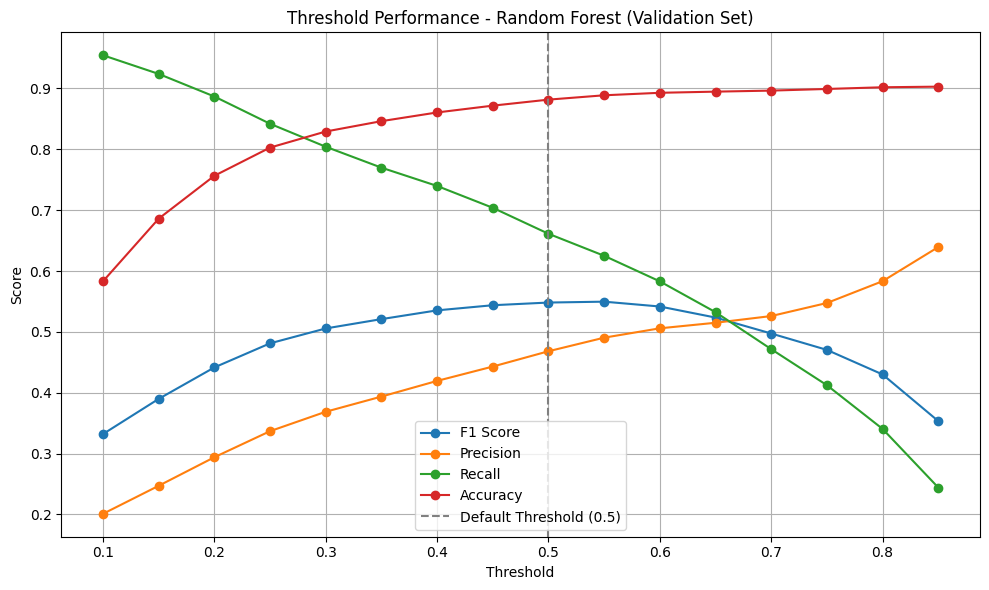

In [60]:
# Plot F1, precision, recall, and accuracy vs. threshold
plot_threshold_metrics(
    thresholds_rf,
    f1_scores_rf,
    precisions_rf,
    recalls_rf,
    accuracies_rf,
    title='Threshold Performance - Random Forest (Validation Set)'
)


This plot shows how dfferent classificatoin thresholds affect the key metrics on the validation set for the **Random Forest** model.
- As the threshold increases, the model becomes more conservative, labeling fewer songs as popular.
-  - This leads to **higher precision** but **lower recall**.
- **Accuracy** continuess to improve as the threshold increases because the non-popular songs are being predicted more often.
- The **F1 Score** peaks at **0.55**, which indicates the most effective cutoff for detecting popular songs.

It helps to use a custom threshold to maximize detecting of top 10% popular songs while balancing false alarms.

In [61]:
# Logistic Regression: Threshold Tuning

# Get predicted probabilities from logistic regression model
y_val_probs = best_logreg.predict_proba(X_val_scaled)[:, 1]

# Store metrics for different thresholds
thresholds = np.arange(0.1, 0.9, 0.05)
f1_scores, precisions, recalls, accuracies = [], [], [], []

for thresh in thresholds:
    y_pred_thresh = (y_val_probs >= thresh).astype(int)
    
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred_thresh, average='binary')
    acc = accuracy_score(y_val, y_pred_thresh)

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    accuracies.append(acc)

# Find best threshold based on F1 score
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"\nBest threshold (by F1-score): {best_threshold:.2f}")
print(f"Precision: {precisions[best_idx]:.2f}, Recall: {recalls[best_idx]:.2f}, F1: {f1_scores[best_idx]:.2f}, Accuracy: {accuracies[best_idx]:.2f}")

# Make final predictions using the best threshold
y_val_pred_lr = (y_val_probs >= best_threshold).astype(int)

# Final Logistic Regression Validation Performance
print("\nLogistic Regression - Validation Set Performance (Threshold = {:.2f}):".format(best_threshold))
print(classification_report(y_val, y_val_pred_lr))


Best threshold (by F1-score): 0.75
Precision: 0.49, Recall: 0.65, F1: 0.56, Accuracy: 0.89

Logistic Regression - Validation Set Performance (Threshold = 0.75):
              precision    recall  f1-score   support

           0       0.96      0.92      0.94     26760
           1       0.49      0.65      0.56      3259

    accuracy                           0.89     30019
   macro avg       0.72      0.78      0.75     30019
weighted avg       0.90      0.89      0.89     30019



Next, we evaluated our **Logistic Regression** performance using the same key metrics as the Random Forest model (F1 score, precision, recall, and accuracy) on the validation set.

The best threshold for the Logistic Regression model, based on F1 Score, is **0.75**. 

Compared to the Random Forest model, Logistic Regression achieves the **same** precision but **higher** recall.

The **accuracy** is also the same as the Random Forest model.

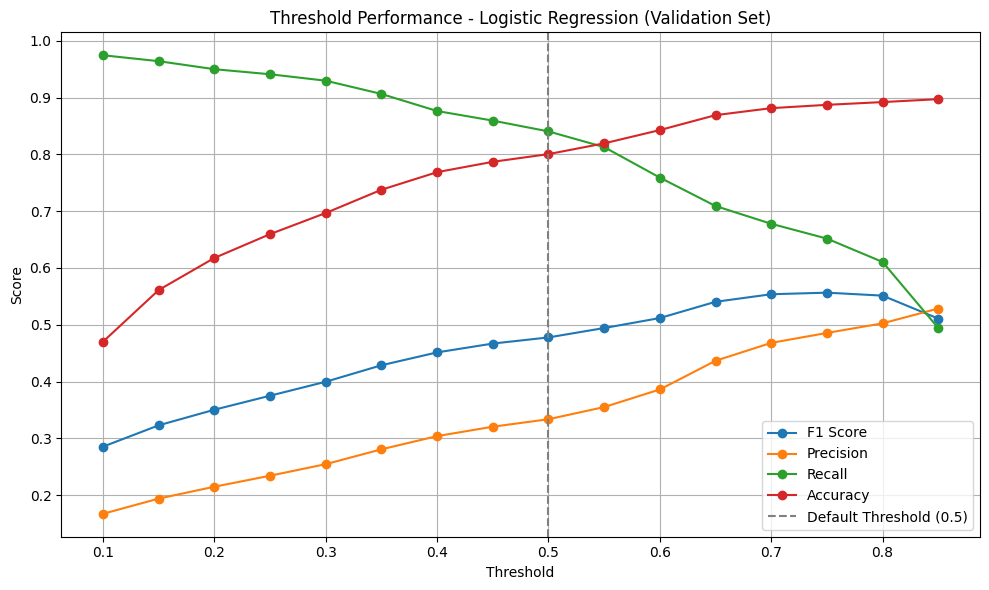

In [62]:
# Plot F1, precision, recall, and accuracy vs. threshold
plot_threshold_metrics(
    thresholds,
    f1_scores,
    precisions,
    recalls,
    accuracies,
    title='Threshold Performance - Logistic Regression (Validation Set)'
)

# Function to plot the confusion matrix
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Popular', 'Popular'],
                yticklabels=['Not Popular', 'Popular'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

Compared to the Random Forest threshold performance chart, the chart for **Logistic Regression** has a lot of the same patterns! The overall line shape that the different thresholds take are very similar to each other.

Of course, this chart shows how different classification thresholds impact our key metrics for the **Logistic Regression** model on the validation set.
- As the threshold increases, **precision** increases but **recall** decreases.
- The **F1 Score** peaks at around threshold of **0.75**. This is quite a balanced trade-off between precision and recall.
- **Accuracy** increases as the threshold increases.

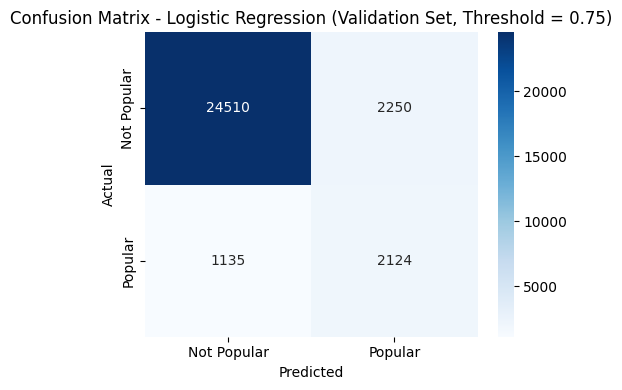

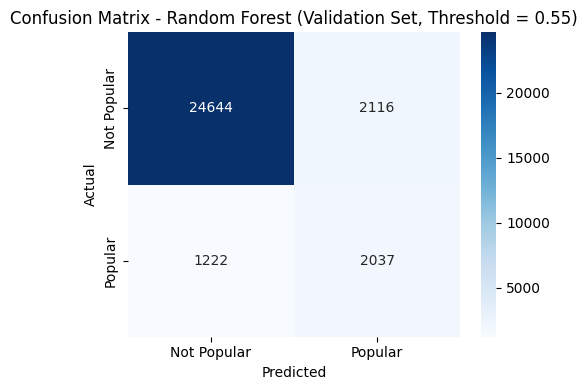

In [63]:
# Confusion matrices at optimized thresholds
plot_conf_matrix(
    y_val,
    y_val_pred_lr,
    f"Confusion Matrix - Logistic Regression (Validation Set, Threshold = {best_threshold:.2f})"
)

plot_conf_matrix(
    y_val,
    y_val_pred_rf_thresh,
    f"Confusion Matrix - Random Forest (Validation Set, Threshold = {best_threshold_rf:.2f})"
)


So far, we've explored a range of thresholds to determine the best balance between our key metrics (F1 score, precision, recall, and accuracy).

We also visualized how performance meetrics change across threesholds. We plotted **confusion matrices** for both models to examine the classification performance in more detail!

These insights help us understand each model's trade-off and guide us in selecting the best model for the final test evaluation.

### **Characterizing Model Performance on Test Set**

After fine-tuning and validating the **Random Forest** model, we will assess its performance on the **test set** using threshold optimization from the validation phase.

This evaluation provides a realistic estimate of how the model will perform in production.

In [64]:
### 7) Characterizing random forest model performance on testing set ###

# 1. Predict probabilities and apply threshold
y_prob_rf = best_rf.predict_proba(X_test)[:, 1]
y_pred_rf = (y_prob_rf >= best_threshold_rf).astype(int)

# 2. Evaluation metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

# Confusion matrix + specificity
cm_rf = confusion_matrix(y_test, y_pred_rf)
tn_rf, fp_rf, fn_rf, tp_rf = cm_rf.ravel()
specificity_rf = tn_rf / (tn_rf + fp_rf)

# Print results
print(f"Random Forest - Test Set (Threshold = {best_threshold_rf:.2f}):")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Sensitivity (Recall): {recall_rf:.4f}")
print(f"Specificity: {specificity_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")
print(f"AUC: {roc_auc_score(y_test, y_prob_rf):.4f}")

Random Forest - Test Set (Threshold = 0.55):
Accuracy: 0.8885
Sensitivity (Recall): 0.6186
Specificity: 0.9214
Precision: 0.4894
F1 Score: 0.5465
AUC: 0.8853


Some remarks:
- The model maintains a **high recall** of 62%, meaning it correctly identifies most of the truly **popular songs**.
- Its **mid-range precision** indicates a considerably high number of false positives.
- The **high accuracy** of 89% suggests the amount of correct predictions.
- The **AUC** being 0.89 shows the model's ability to rank predictions correctly across all thresholds.

The final trade-off suggests that the model captures **popularity clearly**. These insights help solidify the **Random Forest** model's strengths and limitations.

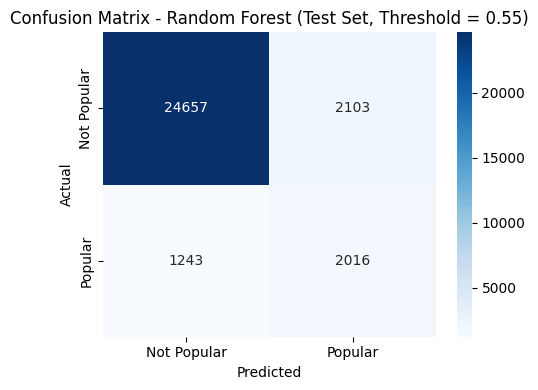

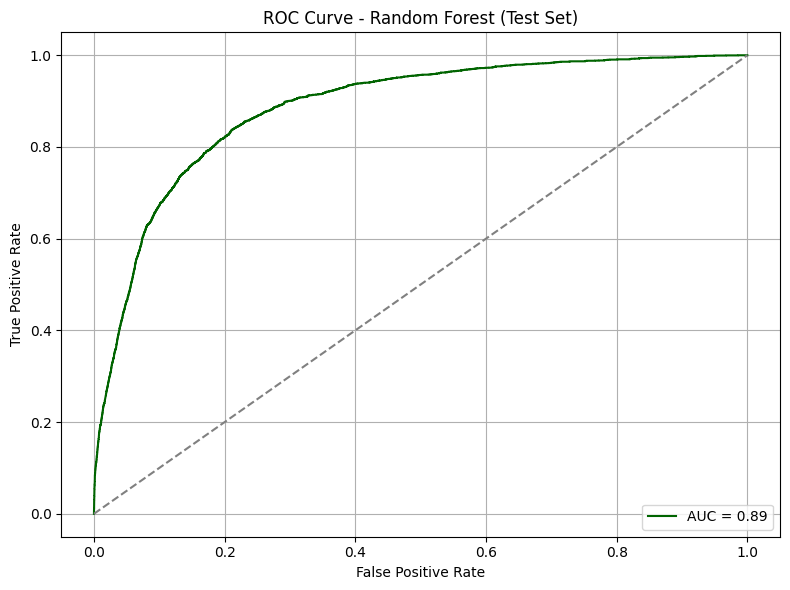

In [65]:
# Plot confusion matrix
plot_conf_matrix(
    y_test,
    y_pred_rf,
    f"Confusion Matrix - Random Forest (Test Set, Threshold = {best_threshold_rf:.2f})"
)

# ROC Curve for Random Forest
def plot_roc_curve(y_true, y_prob, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_score = roc_auc_score(y_true, y_prob)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}', color='darkgreen')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot it
plot_roc_curve(
    y_test,
    y_prob_rf,
    title=f'ROC Curve - Random Forest (Test Set)'
)


The confusion matrix highlights the model's bias toward classifying songs as popular, leading to a lower number of false positives.

The ROC curve for the **Random Forest** test set provides a visual summary of the model's biased ability. An AUC of **0.89** indicates a succesful performance. This suggests that the model is very effective at distinguishing popular songs from non-popular songs.

The model shows a lot of potential, especially in **recall**, but **precision** trade-offs should be considered.

### **Summary**

The Random Forest model demonstrated strong generalization on the test set, effectively handling class imbalance while maintaining solid recall and precision. With an AUC of **0.89**, it shows excellent ranking ability.

This makes the model well-suited for real-world tasks like:
- Identifying potential breakout songs  
- Recommending high-potential tracks  
- Prioritizing songs for marketing or analysis  

Importantly, all evaluations were performed on unseen test data, ensuring reliable and unbiased performance results.